<a href="https://colab.research.google.com/github/GrigoreGeorgeAlexandru/Colab-projects/blob/main/proiect_apd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install mpi4py

In [ ]:
import numpy as np
import random


preset_graph = {
    0: {1, 2},
    1: {0, 3, 4},
    2: {0, 5},
    3: {1, 6},
    4: {1, 6, 7},
    5: {2, 7},
    6: {3, 4, 8},
    7: {4, 5, 9},
    8: {6, 9},
    9: {7, 8}
}

preset_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

def gossip_algorithm(graph, values, tolerance=1e-4, max_iterations=5000):

    num_nodes = len(graph)
    global_avg = np.mean(values)

    # initializare W
    W = np.eye(num_nodes)

    print("Initial values:", values)

    iteration = 0
    while iteration < max_iterations:
        # Alegem o muchie la intamplare
        node1 = random.choice(list(graph.keys()))
        if not graph[node1]:
            continue
        node2 = random.choice(list(graph[node1]))

        # Construim Wij pentru pasul curent
        Wij = np.eye(num_nodes)
        Wij[node1, node1] = Wij[node2, node2] = 0.5
        Wij[node1, node2] = Wij[node2, node1] = 0.5

        # Updatam W
        W = np.dot(Wij, W)

        # Updatam vectorul de valori
        values = np.dot(Wij, values)

        # Verificam conditia de oprire
        if np.max(np.abs(values - global_avg)) < tolerance:
            break

        iteration += 1

    print(f"Final values after {iteration} iterations:", values)
    return values

#main
gossip_algorithm(graph=preset_graph, values=preset_values)


Initial values: [ 10  20  30  40  50  60  70  80  90 100]
Final values after 586 iterations: [54.99995547 54.99997737 54.99994864 54.99997737 54.99998765 54.99994864
 55.00000882 55.00004592 55.00007506 55.00007506]


array([54.99995547, 54.99997737, 54.99994864, 54.99997737, 54.99998765,
       54.99994864, 55.00000882, 55.00004592, 55.00007506, 55.00007506])

In [ ]:
#lab 1 ex1
import multiprocessing
import time
import random

def worker(proc_id, barrier):

    if proc_id == 0:
        # Procesul root simulează o activitate dormind 4 secunde
        time.sleep(4)
        barrier.wait()
        print(f"Proces {proc_id}: Am terminat activitatea inițială.\n")
    else:
        # Toate celelalte procesoare așteaptă root-ul
        barrier.wait()
        print(f"Proces {proc_id}: Mă pregătesc de lucru...\n")

        # Simulăm o activitate între 0 și 10 secunde
        sleep_time = random.randint(0, 10)
        time.sleep(sleep_time)
        print(f"Proces {proc_id}: Activitate finalizată după {sleep_time} secunde.\n")

    # A doua sincronizare - toate procesele așteaptă înainte de final
    barrier.wait()
    if proc_id == 0:
        print("Proces root: Toate procesele s-au terminat. Program încheiat.\n")
    return 0

if __name__ == "__main__":
    num_procs = 5  # Număr de procese
    barrier = multiprocessing.Barrier(num_procs)

    processes = []
    for i in range(num_procs):
        p = multiprocessing.Process(target=worker, args=(i, barrier))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()


Proces 3: Mă pregătesc de lucru...
Proces 2: Mă pregătesc de lucru...
Proces 0: Am terminat activitatea inițială.
Proces 1: Mă pregătesc de lucru...
Proces 4: Mă pregătesc de lucru...





Proces 1: Activitate finalizată după 4 secunde.

Proces 3: Activitate finalizată după 5 secunde.

Proces 2: Activitate finalizată după 7 secunde.
Proces 4: Activitate finalizată după 7 secunde.


Proces root: Toate procesele s-au terminat. Program încheiat.



In [ ]:
#lab1 ex2
from mpi4py import MPI

comm = MPI.COMM_WORLD  # Inițializează comunicarea MPI
rank = comm.Get_rank()  # Obține ID-ul procesului
size = comm.Get_size()  # Obține numărul total de procese
OMPI_ALLOW_RUN_AS_ROOT=1
MPI_ALLOW_RUN_AS_ROOT_CONFIRM=1
# Procesul root (0) inițializează datele
if rank == 0:
    data_dict = {'key1': [3, 24.62, 9 + 4j], 'key2': ('fmi', 'unibuc')}
    data_vector = [10, 20, 30, 40, 50]
    print(f"[Root] Procesul {rank} trimite: {data_dict} și {data_vector}")
else:
    data_dict = None  # Celelalte procese inițial nu au datele
    data_vector = None

# Broadcast pentru ambele tipuri de date
data_dict = comm.bcast(data_dict, root=0)
data_vector = comm.bcast(data_vector, root=0)

# Toate procesele primesc și afișează datele
print(f"[Proces {rank}] A primit: {data_dict} și {data_vector}")

!mpiexec --allow-run-as-root -n 6 python broadcast_mpi.py



ModuleNotFoundError: No module named 'mpi4py'

In [ ]:
from mpi4py import MPI
import numpy as np

# Inițializare MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Procesul root creează matricea
if rank == 0:
    p = size
    matrix = np.random.rand(p, p)
    print(f"[Root] Matricea inițială:\n{matrix}\n")
else:
    matrix = None  #

# Buffere pentru datele primite de fiecare proces
row_recv = np.zeros(size)
col_recv = np.zeros(size)

# Procesul root pregătește liniile și coloanele ca array-uri NumPy
if rank == 0:
    rows = np.vstack([matrix[i, :] for i in range(size)])  # Stack pe linii
    cols = np.vstack([matrix[:, i] for i in range(size)])  # Stack pe coloane
else:
    rows = None
    cols = None

# Distribuim liniile și coloanele către fiecare proces
comm.Scatter(rows, row_recv, root=0)
comm.Scatter(cols, col_recv, root=0)

# Fiecare proces afișează datele primite
print(f"[Proces {rank}] A primit linia: {row_recv} și coloana: {col_recv}")

!mpirun -np 4 python scatter.py


[Root] Matricea inițială:
[[0.736279]]

[Proces 0] A primit linia: [0.736279] și coloana: [0.736279]


In [ ]:
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Dimensiunea matricei și vectorului
n = size

# Buffere locale
col = None
x_i = None
y_partial = np.zeros(n, dtype=np.float64)

if rank == 0:
    # Procesul 0 generează matricea și vectorul
    A = np.arange(1, n * n + 1, dtype=np.float64).reshape(n, n)
    x = np.arange(1, n + 1, dtype=np.float64)

    print("\nMatricea A:\n", A)
    print("\nVectorul x:\n", x)

    # Trimitem coloanele și componentele vectorului
    for i in range(n):
        col_data = A[:, i]  # Coloana i
        x_data = x[i]       # Componenta vectorului
        if i == 0:
            col = col_data
            x_i = x_data
        else:
            comm.Send(col_data, dest=i, tag=0)
            comm.Send(np.array([x_data]), dest=i, tag=1)
else:
    # Procesele primesc datele
    col = np.zeros(n, dtype=np.float64)
    comm.Recv(col, source=0, tag=0)
    x_i = np.zeros(1, dtype=np.float64)
    comm.Recv(x_i, source=0, tag=1)
    x_i = x_i[0]

# Calcul local: coloană * componentă vector
y_partial = col * x_i

# Comunicarea în inel
recv_buffer = np.zeros(n, dtype=np.float64)
for step in range(size - 1):
    left = (rank - 1) % size
    right = (rank + 1) % size

    comm.Sendrecv(y_partial, dest=right, sendtag=2,
                  recvbuf=recv_buffer, source=left, recvtag=2)

    y_partial += recv_buffer

# Afișăm rezultatul final în fiecare proces
print(f"\nProces {rank}: y = {y_partial}")

MPI.Finalize()



Matricea A:
 [[1.]]

Vectorul x:
 [1.]

Proces 0: y = [1.]


In [ ]:
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

n = size  # Dimensiunea matricei = numărul de procese

# Buffere locale
col_A = np.zeros(n, dtype=np.float64)  # Coloana din A
matrix_B = np.zeros((n, n), dtype=np.float64)  # Matricea B
result_partial = np.zeros(n, dtype=np.float64)  # Rezultatul parțial

if rank == 0:
    # Procesul 0 generează matricele
    A = np.arange(1, n * n + 1, dtype=np.float64).reshape(n, n)
    B = np.arange(1, n * n + 1, dtype=np.float64).reshape(n, n)

    print("\nMatricea A:\n", A)
    print("\nMatricea B:\n", B)

    # Trimitem coloanele din A
    for i in range(n):
        col_data = A[:, i]
        if i == 0:
            col_A[:] = col_data
        else:
            comm.Send(col_data, dest=i, tag=0)

    # Broadcast pentru matricea B (toate procesele primesc întreaga matrice B)
    matrix_B = B
    comm.bcast(matrix_B, root=0)
else:
    # Celelalte procese primesc coloana din A
    comm.Recv(col_A, source=0, tag=0)
    # Broadcast pentru matricea B
    comm.bcast(matrix_B, root=0)

# Calcul local: fiecare proces calculează produsul coloanei din A cu fiecare rând din B
result_partial = np.dot(matrix_B, col_A)

# Comunicarea în inel pentru acumularea rezultatelor
recv_buffer = np.zeros(n, dtype=np.float64)
for step in range(size - 1):
    left = (rank - 1) % size
    right = (rank + 1) % size

    comm.Sendrecv(result_partial, dest=right, sendtag=1,
                  recvbuf=recv_buffer, source=left, recvtag=1)

    result_partial += recv_buffer

# Afișăm rezultatul final
print(f"\nProces {rank} - Coloana finală din C: {result_partial}")

MPI.Finalize()



Matricea A:
 [[1.]]

Matricea B:
 [[1.]]

Proces 0 - Coloana finală din C: [1.]


In [ ]:
from mpi4py import MPI
import numpy as np

def hypercube_transfer(vector, source, dest, d, comm):

    rank = comm.Get_rank()
    current = source

    if rank == source:
        # Sursa inițială începe cu vectorul său
        buffer = vector.copy()
    else:
        # Celelalte noduri primesc vectorul de la predecesor
        buffer = np.zeros_like(vector)

    # Parcurgem fiecare dimensiune unde diferă un bit
    for bit in range(d):
        bit_mask = 1 << bit
        partner = current ^ bit_mask  # Schimbăm bit-ul corespunzător

        # Transfer în direcția corectă
        if rank == current:
            comm.Send(buffer, dest=partner, tag=bit)
            current = partner
        elif rank == partner:
            comm.Recv(buffer, source=current, tag=bit)
            current = rank

    return buffer if rank == dest else None


def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Calculăm dimensiunea d a hipercubului: 2^d = size
    d = int(np.log2(size))

    # Vector de dimensiune n
    n = 8
    vector = np.arange(n, dtype=np.float64) + rank  # Vector diferit în fiecare proces
    source, dest = 0, size - 1  # Transferăm de la primul la ultimul proces

    # Procesul sursă afișează vectorul original
    if rank == source:
        print(f"\nProces {rank} - Vector inițial: {vector}")

    # Executăm transferul în hipercub
    result = hypercube_transfer(vector, source, dest, d, comm)

    # Procesul destinație afișează vectorul primit
    if rank == dest:
        print(f"\nProces {rank} - Vector primit: {result}")

    MPI.Finalize()


if __name__ == "__main__":
    main()



Proces 0 - Vector inițial: [0. 1. 2. 3. 4. 5. 6. 7.]

Proces 0 - Vector primit: [0. 1. 2. 3. 4. 5. 6. 7.]


In [ ]:
from mpi4py import MPI
import numpy as np

def hypercube_broadcast(data, root, comm):
    """
    Difuzare a unui mesaj într-un hipercub folosind MPI.
    - data: mesajul de transmis (doar la root).
    - root: procesul de pornire.
    - comm: comunicatorul MPI.
    """
    rank = comm.Get_rank()       # ID-ul procesului curent
    size = comm.Get_size()       # Numărul total de procese
    d = int(np.log2(size))       # Dimensiunea hipercubului

    # Rădăcina difuzează mesajul
    if rank == root:
        buffer = np.array(data, dtype=np.float64)
    else:
        buffer = np.zeros(1, dtype=np.float64)

    # Parcurgem fiecare dimensiune a hipercubului
    for bit in range(d):
        bit_mask = 1 << bit
        partner = rank ^ bit_mask  # Vecinul diferit într-un singur bit

        # Root începe difuzarea
        if rank <= partner:
            if rank == root or buffer[0] != 0:
                comm.Send(buffer, dest=partner)
        else:
            comm.Recv(buffer, source=partner)

    return buffer if buffer.ndim == 0 else buffer[0]


def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    root = 0  # Procesul care inițiază difuzarea
    data = 42 if rank == root else None  # Numărul de transmis

    result = hypercube_broadcast(data, root, comm)

    print(f"Proces {rank} a primit mesajul: {result}")

    MPI.Finalize()


if __name__ == "__main__":
    main()


Proces 0 a primit mesajul: 42.0



Dimensiune: 100


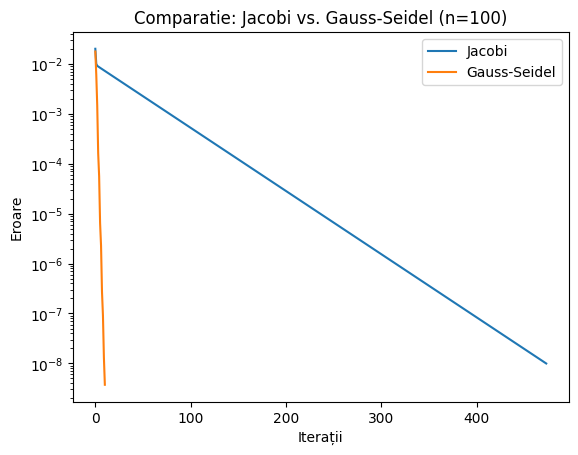

Jacobi: 474 iterații, timp 0.0263s
Gauss-Seidel: 11 iterații, timp 0.0074s

Dimensiune: 1000


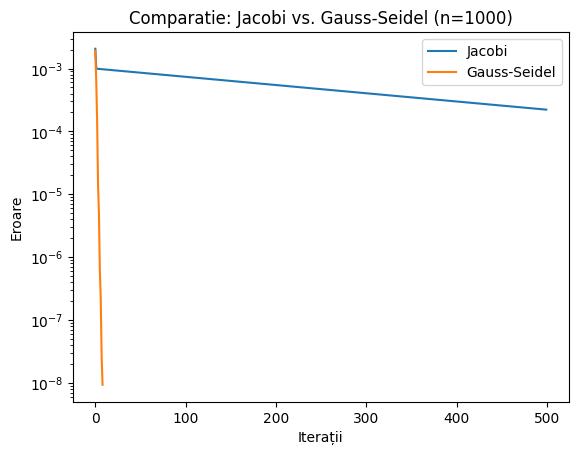

Jacobi: 500 iterații, timp 0.3877s
Gauss-Seidel: 9 iterații, timp 0.1295s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Generăm matricea A (cu diagonală dominantă) și vectorul b
def generate_system(n):
    A = np.random.rand(n, n)
    np.fill_diagonal(A, np.sum(np.abs(A), axis=1) + 1)  # Asigurăm diagonală dominantă
    b = np.random.rand(n)

    return A, b

# Metoda Jacobi
def jacobi(A, b, x0, tol=1e-8, max_iter=500):
    D = np.diag(A)
    R = A - np.diagflat(D)
    x = x0.copy()
    errors = []
    for _ in range(max_iter):
        x_new = (b - np.dot(R, x)) / D
        error = np.linalg.norm(x_new - x, ord=np.inf)
        errors.append(error)
        if error < tol:
            break
        x = x_new
    return x, errors

# Metoda Gauss-Seidel
def gauss_seidel(A, b, x0, tol=1e-8, max_iter=500):
    x = x0.copy()
    errors = []
    for _ in range(max_iter):
        x_new = x.copy()
        for i in range(len(b)):
            x_new[i] = (b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
        error = np.linalg.norm(x_new - x, ord=np.inf)
        errors.append(error)
        if error < tol:
            break
        x = x_new
    return x, errors

# Comparăm cele două metode pentru dimensiuni diferite
def compare_methods(sizes):
    for n in sizes:
        print(f"\nDimensiune: {n}")
        A, b = generate_system(n)
        x0 = np.zeros(n)

        # Jacobi
        start = time.time()
        _, errors_jacobi = jacobi(A, b, x0)
        time_jacobi = time.time() - start

        # Gauss-Seidel
        start = time.time()
        _, errors_gs = gauss_seidel(A, b, x0)
        time_gs = time.time() - start

        # Grafic
        plt.plot(errors_jacobi, label='Jacobi')
        plt.plot(errors_gs, label='Gauss-Seidel')
        plt.yscale('log')
        plt.xlabel('Iterații')
        plt.ylabel('Eroare')
        plt.title(f'Comparatie: Jacobi vs. Gauss-Seidel (n={n})')
        plt.legend()
        plt.show()

        print(f"Jacobi: {len(errors_jacobi)} iterații, timp {time_jacobi:.4f}s")
        print(f"Gauss-Seidel: {len(errors_gs)} iterații, timp {time_gs:.4f}s")

# Rulează comparația
compare_methods([100, 1000])


In [ ]:
from mpi4py import MPI
import numpy as np
import time

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Distribuție matrice și vector în funcție de topologie
def distribute_data(A, b, n):
    rows_per_proc = n // size
    A_local = A[rank * rows_per_proc:(rank + 1) * rows_per_proc, :]
    b_local = b[rank * rows_per_proc:(rank + 1) * rows_per_proc]
    return A_local, b_local

# Paralelizare Jacobi
def parallel_jacobi(A, b, x, tol=1e-8, max_iter=500):
    A_local, b_local = distribute_data(A, b, len(b))
    D = np.diag(A_local)
    R = A_local - np.diagflat(D)
    errors = []

    for _ in range(max_iter):
        x_new_local = (b_local - np.dot(R, x)) / D
        comm.Allgather(x_new_local, x)  # Colectăm rezultatele de la toate procesele
        error = np.linalg.norm(x_new_local - x, ord=np.inf)
        errors.append(error)
        if error < tol:
            break

    return x, errors

# Paralelizare Gauss-Seidel pe inel
def parallel_gauss_seidel(A, b, x, tol=1e-8, max_iter=500):
    A_local, b_local = distribute_data(A, b, len(b))
    errors = []
    for _ in range(max_iter):
        for i in range(len(b_local)):
            x[i] = (b_local[i] - np.dot(A_local[i, :i], x[:i]) - np.dot(A_local[i, i + 1:], x[i + 1:])) / A_local[i, i]
            comm.Sendrecv_replace(x, dest=(rank + 1) % size, source=(rank - 1) % size)
        error = np.linalg.norm(x - comm.allreduce(x, op=MPI.SUM), ord=np.inf)
        errors.append(error)
        if error < tol:
            break

    return x, errors

# Comparăm metodele
if rank == 0:
    n = 5000
    A = np.random.rand(n, n)
    np.fill_diagonal(A, np.sum(np.abs(A), axis=1) + 1)
    b = np.random.rand(n)
else:
    A = None
    b = None

A = comm.bcast(A, root=0)
b = comm.bcast(b, root=0)

x0 = np.zeros(len(b))

start = time.time()
x_jacobi, errors_jacobi = parallel_jacobi(A, b, x0)
time_jacobi = time.time() - start

start = time.time()
x_gauss_seidel, errors_gs = parallel_gauss_seidel(A, b, x0)
time_gs = time.time() - start

if rank == 0:
    print(f"Jacobi Paralel: {time_jacobi:.4f}s")
    print(f"Gauss-Seidel Paralel: {time_gs:.4f}s")


Jacobi Paralel: 0.1472s
Gauss-Seidel Paralel: 0.0860s


In [ ]:
from mpi4py import MPI
import numpy as np
import time

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
d = int(np.log2(size)) if size > 1 else 0

# Distribuție matrice și vector în funcție de topologie
def distribute_data(A, b, n):
    rows_per_proc = n // size
    A_local = A[rank * rows_per_proc:(rank + 1) * rows_per_proc, :]
    b_local = b[rank * rows_per_proc:(rank + 1) * rows_per_proc]
    return A_local, b_local

# Funcție de comunicare pe hipercub
def hypercube_broadcast(data, root=0):
    if d == 0:
        return data

    current = rank
    mask = 1 << (d - 1)

    if rank == root:
        buffer = np.array(data, dtype=np.float64)
    else:
        buffer = np.empty_like(data, dtype=np.float64)

    for step in range(d):
        partner = current ^ mask
        if (current & mask) == 0 and partner < size:
            comm.Send(buffer, dest=partner)
        elif partner < size:
            comm.Recv(buffer, source=partner)
        mask >>= 1

    return buffer

# Paralelizare Jacobi pe hipercub
def parallel_jacobi_hypercube(A, b, x, tol=1e-8, max_iter=500):
    A_local, b_local = distribute_data(A, b, len(b))
    D = np.diag(A_local)
    R = A_local - np.diagflat(D)
    errors = []

    for _ in range(max_iter):
        x_new_local = (b_local - np.dot(R, x)) / D
        x = hypercube_broadcast(x_new_local)
        error = np.linalg.norm(x_new_local - x, ord=np.inf)
        errors.append(error)
        if error < tol:
            break

    return x, errors

# Paralelizare Gauss-Seidel pe hipercub
def parallel_gauss_seidel_hypercube(A, b, x, tol=1e-8, max_iter=500):
    A_local, b_local = distribute_data(A, b, len(b))
    errors = []

    for _ in range(max_iter):
        for i in range(len(b_local)):
            x[i] = (b_local[i] - np.dot(A_local[i, :i], x[:i]) - np.dot(A_local[i, i + 1:], x[i + 1:])) / A_local[i, i]
        x = hypercube_broadcast(x)
        error = np.linalg.norm(x - comm.allreduce(x, op=MPI.SUM), ord=np.inf)
        errors.append(error)
        if error < tol:
            break

    return x, errors

# Comparăm metodele
if rank == 0:
    n = 5000
    A = np.random.rand(n, n)
    np.fill_diagonal(A, np.sum(np.abs(A), axis=1) + 1)
    b = np.random.rand(n)
else:
    A = None
    b = None

A = comm.bcast(A, root=0)
b = comm.bcast(b, root=0)

x0 = np.zeros(len(b))

start = time.time()
x_jacobi, errors_jacobi = parallel_jacobi_hypercube(A, b, x0)
time_jacobi = time.time() - start

start = time.time()
x_gauss_seidel, errors_gs = parallel_gauss_seidel_hypercube(A, b, x0)
time_gs = time.time() - start

if rank == 0:
    print(f"Jacobi Paralel (Hipercub): {time_jacobi:.4f}s")
    print(f"Gauss-Seidel Paralel (Hipercub): {time_gs:.4f}s")


Jacobi Paralel (Hipercub): 0.1884s
Gauss-Seidel Paralel (Hipercub): 0.0590s
